## Install Libraries

In [1]:
!pip3 install torch torchvision

In [2]:
import torch
import torchvision

In [3]:
# Uncompress files
!tar xvzf ../input/200-bird-species-with-11788-images/CUB_200_2011.tgz


attributes.txt
CUB_200_2011/
CUB_200_2011/images/
CUB_200_2011/images/001.Black_footed_Albatross/
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0010_796097.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0032_796115.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0057_796106.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0036_796127.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0060_796076.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0019_796104.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0069_796139.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0089_796069.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0071_796113.jpg
CUB_200_2011/images/001.Black_footed_Albatross/Black_Footed_Albatross_0077_796114.jpg
CUB_200_2011/images/001.Black_footed_Albat

## Modelling

### Importing Required Libraries

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
import cv2
import matplotlib.pyplot as plt

**read_image()** functions reads image and converts it from BGR to RGB as opencv used BGR while matplotlib uses RGB. So, we need to make this conversion so we can easily visualize the data

In [5]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [6]:
# Data Augmentation
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

**normalize()** to normalize each image using imagenet stats

In [7]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im/255.0 - imagenet_stats[0])/imagenet_stats[1]

**apply_transform()** it lists the transformation we want to apply to image before we feed it to the model.

In [8]:
def apply_transforms(x, sz=(224, 224), zoom=1.05):
    """ Applies a random crop, rotation"""
    sz1 = int(zoom*sz[0])
    sz2 = int(zoom*sz[1])
    x = cv2.resize(x, (sz1, sz2))
    x = rotate_cv(x, np.random.uniform(-10,10))
    x = random_crop(x, sz[1], sz[0])
    if np.random.rand() >= .5:
                x = np.fliplr(x).copy()
    return x

**denormalize()** transformed images so we can easily visualize using matplotlib

In [9]:
def denormalize(img):
  imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
  return img*imagenet_stats[1] + imagenet_stats[0]

Function to display images which we transformed obtained wither from dataset or dataloader 

In [10]:
def show_image(img):
  img = img.transpose(1,2,0)
  img= denormalize(img)
  plt.imshow(img)


In [11]:
def visualize(dataloader, categories):
    """Imshow for Tensor."""
    x,y = next(iter(dataloader))
    
    fig = plt.figure(figsize=(10, 10))
    for i in range(8):
      inp = x[i]
      inp = inp.numpy().transpose(1,2,0)
      inp = denormalize(inp)
      
      ax = fig.add_subplot(2, 4, i+1, xticks=[], yticks=[])
      plt.imshow(inp)
      plt.title(str(categories[y[i]]))
      
      
      


In [12]:
PATH = Path('./CUB_200_2011')
labels = pd.read_csv(PATH/"image_class_labels.txt", header=None, sep=" ")
labels.columns = ["id", "label"]
labels.head(2)

,id,label
0,1,1
1,2,1


In [13]:
labels.describe()

,id,label
count,11788.000000,11788.000000
mean,5894.500000,101.126315
std,3403.046821,57.476826
min,1.000000,1.000000
25%,2947.750000,51.000000
50%,5894.500000,101.000000
75%,8841.250000,151.000000
max,11788.000000,200.000000


In [14]:
train_test = pd.read_csv(PATH/"train_test_split.txt", header=None, sep=" ")
train_test.columns = ["id", "is_train"]
train_test.head(2)

,id,is_train
0,1,0
1,2,1


In [15]:
images = pd.read_csv(PATH/"images.txt", header=None, sep=" ")
images.columns = ["id", "name"]
images.head(2)

,id,name
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...


In [16]:
classes = pd.read_csv(PATH/"classes.txt", header=None, sep=" ")
classes.columns = ["id", "class"]
classes.head(2)

,id,class
0,1,001.Black_footed_Albatross
1,2,002.Laysan_Albatross


In [17]:
categories = [x for x in classes["class"]]

### Creating DataSet

In [18]:
class CUB(Dataset):
    def __init__(self, files_path, labels, train_test, image_name, train=True, 
                 transform=False):
      
        self.files_path = files_path
        self.labels = labels
        self.transform = transform
        self.train_test = train_test
        self.image_name = image_name
        
        if train:
          mask = self.train_test.is_train.values == 1
          
        else:
          mask = self.train_test.is_train.values == 0
        
        
        self.filenames = self.image_name.iloc[mask]
        self.labels = self.labels[mask]
        self.num_files = self.labels.shape[0]
       
      
        
    def __len__(self):
        return self.num_files
    
    def __getitem__(self, index):
        y = self.labels.iloc[index,1] - 1
        
        file_name = self.filenames.iloc[index, 1]
        path = self.files_path/'images'/file_name
        x = read_image(path)
        if self.transform:
            x = apply_transforms(x)
        else:
            x = cv2.resize(x, (224,224))
        x = normalize(x)
        x =  np.rollaxis(x, 2) # To meet torch's input specification(c*H*W) 
        return x,y

In [19]:
train_dataset = CUB(PATH, labels, train_test, images, train= True, transform= True)
valid_dataset = CUB(PATH, labels, train_test, images, train= False, transform= False)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=64, num_workers=4)

**Lets visualize the model**

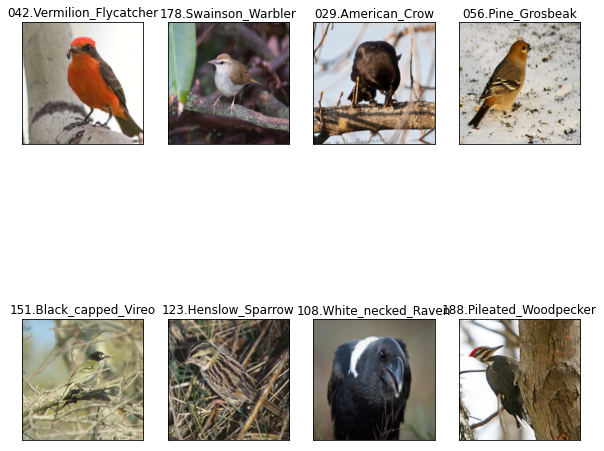

In [21]:
visualize(train_loader, categories)

In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 200)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [23]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [24]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=1, beta=0.9):
  losses = []
  # Model save path
  p = PATH/"mode_tmp.pth"
  save_model(model, str(p))
  num = len(train_dl)-1
  mult = (lr_high / lr_low) ** (1.0/num)
  lr = lr_low
  avg_loss = 0.
  best_loss = 0.
  batch_num = 0
  log_lrs = []

  model.train()
  for i in range(epochs):
    for x,y in train_dl:
      batch_num +=1
      optim = get_optimizer(model, lr=lr)
      x = x.cuda().float()
      y = y.cuda().long()   
      out = model(x)
      criterion = nn.CrossEntropyLoss()
      loss = criterion(out, y)

      #Compute the smoothed loss
      avg_loss = beta * avg_loss + (1-beta) *loss.item()
      smoothed_loss = avg_loss / (1 - beta**batch_num)

      #Stop if the loss is exploding
      if batch_num > 1 and smoothed_loss > 4 * best_loss:
        return log_lrs, losses

      #Record the best loss
      if smoothed_loss < best_loss or batch_num==1:
        best_loss = smoothed_loss
      #Store the values
      losses.append(smoothed_loss)
      log_lrs.append(math.log10(lr))

      optim.zero_grad()
      loss.backward()
      optim.step()
      #Update the lr for the next step
      lr *= mult
  load_model(model, str(p))
  return log_lrs, losses

In [25]:
def get_triangular_lr(lr_low, lr_high, iterations):
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3



In [26]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, 
                            lr_high=0.01, epochs = 4):
    idx = 0
    iterations = epochs*len(train_dl)
    lrs = get_triangular_lr(lr_low, lr_high, iterations)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            y = y.cuda().long()
            out = model(x)
            criterion = nn.CrossEntropyLoss()
            loss = criterion(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total



### Validation Metric

In [27]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for x, y in valid_dl:
        batch = y.shape[0]
        x = x.cuda().float()
        y = y.cuda().long()
        out = model(x)
        _, pred = torch.max(out, 1)
        correct += pred.eq(y.data).sum().item()
        y = y.long()
        criterion = nn.CrossEntropyLoss()
        loss = criterion(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)

### Training Loop

In [28]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-6, lr_high=0.01, epochs = 4):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high, epochs)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

## Model training

In [29]:
model = Net().cuda()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

### Finding best learning rate(keeping 7 layers freezed)

In [30]:

lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-6, lr_high=0.1)

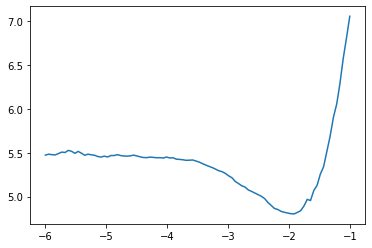

In [31]:
plt.plot(lrs, losses)
plt.show()

In [32]:
val_metrics(model, valid_loader)

val loss and accuracy 5.350784777771986 0.005868139454608215


In [33]:

training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-3, lr_high=1*1e-2, epochs = 16)

train loss 4.708931956006401
val loss and accuracy 4.6004043957016 0.19744563341387641
train loss 4.563762740847028
val loss and accuracy 4.49801724789099 0.18277528477735588
train loss 4.331880982335027
val loss and accuracy 4.277067911637253 0.1770797376596479
train loss 4.081858217775881
val loss and accuracy 4.121986637043056 0.1829478771142561
train loss 3.8979963397916095
val loss and accuracy 4.010095663304407 0.22540559199171556
train loss 3.7121160637349893
val loss and accuracy 3.9993618202077794 0.22782188470831896
train loss 3.426985482354939
val loss and accuracy 3.7115785613897794 0.27183293061788055
train loss 3.1689261437894345
val loss and accuracy 3.555408438773743 0.2954780807732137
train loss 2.9953139127394657
val loss and accuracy 3.4514398010261806 0.3324128408698654
train loss 3.012829470483311
val loss and accuracy 3.472570623905444 0.3674490852606144
train loss 3.0587721197932094
val loss and accuracy 3.6768438594687756 0.3553676216775975
train loss 3.29276090

In [34]:
p = PATH/"model1_tmp.pth"
save_model(model, str(p))
load_model(model, str(p))

### Unfreeze the layers

In [35]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [36]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [37]:
unfreeze(model, 7)
unfreeze(model, 6)
unfreeze(model, 5)

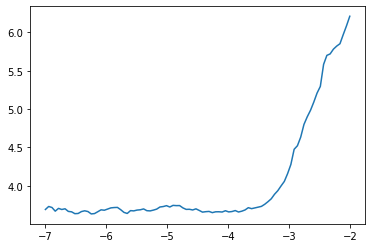

In [38]:
#New
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-7, lr_high=0.01)
plt.plot(lrs, losses)
plt.show()

In [39]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-5, lr_high=1*1e-4, epochs = 30)

train loss 3.6204012111699457
val loss and accuracy 4.065467058233775 0.3336209872281671
train loss 3.445633426363324
val loss and accuracy 3.8574772534553126 0.38695201933034173
train loss 3.3040448723533054
val loss and accuracy 3.6371898180375974 0.43061788056610284
train loss 3.171213226872044
val loss and accuracy 3.611125605247084 0.44390749050742145
train loss 3.042593908500862
val loss and accuracy 3.4346546907856172 0.5058681394546082
train loss 2.9155923264560437
val loss and accuracy 3.4372086261608374 0.4782533655505696
train loss 2.7580384718087023
val loss and accuracy 3.4778094104869552 0.5308940283051432
train loss 2.5797145283934193
val loss and accuracy 3.2070056501651245 0.5322747670003452
train loss 2.408055579618569
val loss and accuracy 2.909637541124069 0.5907835692095271
train loss 2.2397606811962567
val loss and accuracy 2.9790013852019044 0.5595443562305834
train loss 2.0195142175899092
val loss and accuracy 2.704546340794904 0.6116672419744563
train loss 1.79

In [40]:
p = PATH/"model2_tmp.pth"
save_model(model, str(p))
load_model(model, str(p))

### Unfreezing few more layers

In [41]:
load_model(model, str(p))
unfreeze(model, 4)
unfreeze(model, 3)
unfreeze(model,2)

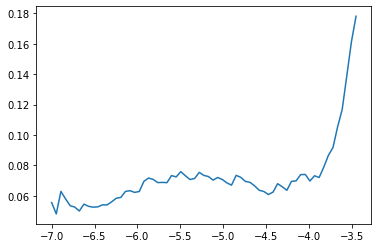

In [42]:
lrs, losses = LR_range_finder(model, train_loader, lr_low=1e-7, lr_high=0.01)
plt.plot(lrs, losses)
plt.show()

In [43]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-7, lr_high=1*1e-5, epochs = 10)

train loss 0.4344123099440529
val loss and accuracy 1.7068015612278638 0.6839834311356576
train loss 0.20236618358928998
val loss and accuracy 1.4783071140029902 0.7304107697618226
train loss 0.10096968263934603
val loss and accuracy 1.390035467370856 0.7435277873662409
train loss 0.07036060752259479
val loss and accuracy 1.34077536475465 0.7480151881256473
train loss 0.056015145979525845
val loss and accuracy 1.3378915181541016 0.7474974111149465
train loss 0.05026508375510081
val loss and accuracy 1.3131801540538035 0.7526751812219538
train loss 0.045842372708850436
val loss and accuracy 1.3087285830721922 0.7526751812219538
train loss 0.044043485505315595
val loss and accuracy 1.300336099530978 0.7504314808422506
train loss 0.043499315639197685
val loss and accuracy 1.316137225978902 0.7525025888850535
train loss 0.043695927971416526
val loss and accuracy 1.2984342918874974 0.7493959268208491
----End of step Time elapsed 0:12:26.042211


In [44]:
training_loop(model, train_loader, valid_loader, steps=1, lr_low= 1e-7, lr_high=5*1e-7, epochs = 10)

train loss 0.04175892382149184
val loss and accuracy 1.3037266544753368 0.7473248187780462
train loss 0.04223720735566076
val loss and accuracy 1.3051198389577916 0.7506040731791509
train loss 0.04324683664484067
val loss and accuracy 1.302391481648489 0.7514670348636521
train loss 0.04198395370850374
val loss and accuracy 1.3073644165051244 0.7511218501898516
train loss 0.043701708285727815
val loss and accuracy 1.3000951305438124 0.7512944425267518
train loss 0.041440371748384414
val loss and accuracy 1.291758432866048 0.752157404211253
train loss 0.040793938073150945
val loss and accuracy 1.3058695629172214 0.754228512254056
train loss 0.04050478762811846
val loss and accuracy 1.303876317088506 0.7519848118743527
train loss 0.041986079149452855
val loss and accuracy 1.2909563341694617 0.7511218501898516
train loss 0.04086074843246976
val loss and accuracy 1.3077352487366076 0.7506040731791509
----End of step Time elapsed 0:12:25.075634
